# Cell 1: Imports & Configuration
Import necessary libraries and set up configuration parameters.

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import csv
import gc
import zipfile
import shutil

# TensorFlow/Keras imports
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'  # Force dynamic memory allocation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# ============================================
# GPU/CPU CONFIGURATION - KAGGLE T4 x2 (30GB Total)
# ============================================
print("Checking for GPU...")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Kaggle T4 Configuration: 15GB per GPU, allocate 12GB per GPU (leave 3GB margin)
        # With 2 T4s, total usable: ~24GB
        GPU_MEMORY_PER_GPU = 12000  # 12GB per T4
        
        # Configure logical devices BEFORE any memory growth
        # This approach is cleaner and avoids conflicts
        for gpu in gpus:
            try:
                tf.config.set_logical_device_configuration(
                    gpu,
                    [tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEMORY_PER_GPU)]
                )
            except RuntimeError:
                # If device is already configured, enable memory growth instead
                tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✓ GPU DETECTED: {len(gpus)} device(s)")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu}")
        
        print(f"  Memory per GPU: {GPU_MEMORY_PER_GPU / 1000:.1f} GB (conservative for stability)")
        print(f"  Total usable: ~{len(gpus) * GPU_MEMORY_PER_GPU / 1000:.1f} GB")
        print(f"✓ DUAL GPU ACCELERATION ENABLED (T4 x2)! 🚀")
    except RuntimeError as e:
        print(f"⚠ GPU configuration error: {e}")
        print("   Attempting fallback: enabling memory growth...")
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("   ✓ Memory growth enabled as fallback")
        except:
            print("   ⚠ Could not configure GPU memory. Training may still work.")
else:
    print("⚠ No GPU detected. Using CPU for training")

# ============================================
# KAGGLE NOTEBOOK CONFIGURATION & ZIP EXTRACTION
# ============================================
# Kaggle data path: /kaggle/input/{dataset-name}/
# For local testing or custom paths, adjust accordingly
import os
import glob

# Check if running on Kaggle
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    # Running on Kaggle - adjust paths
    BASE_DIR = Path('/kaggle/working')
    KAGGLE_INPUT = Path('/kaggle/input')
    
    print("\n" + "=" * 50)
    print("Checking for ZIP files in Kaggle input...")
    print("=" * 50)
    
    # Find and extract ZIP files
    zip_files = list(KAGGLE_INPUT.glob('**/*.zip'))
    
    if zip_files:
        print(f"Found {len(zip_files)} ZIP file(s)")
        
        for zip_path in zip_files:
            print(f"\n📦 Processing: {zip_path.name}")
            # Extract to /kaggle/working (writable directory)
            extract_dir = BASE_DIR / zip_path.stem
            
            if not extract_dir.exists():
                print(f"   → Extracting to: {extract_dir}")
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                print(f"   ✓ Extraction complete!")
                
                # List what was extracted
                extracted_items = list(extract_dir.iterdir())
                print(f"   ✓ Extracted {len(extracted_items)} item(s)")
            else:
                print(f"   ✓ Already extracted to: {extract_dir}")
    else:
        print("No ZIP files found")
    
    # Show structure of /kaggle/input for debugging
    print("\n" + "=" * 50)
    print("Kaggle Input Directory Structure:")
    print("=" * 50)
    if KAGGLE_INPUT.exists():
        for item in sorted(KAGGLE_INPUT.iterdir()):
            print(f"   - {item.name}")
    
    # Now search for dataset_processed folder (including extracted ones)
    print("\n" + "=" * 50)
    print("Searching for dataset_processed...")
    print("=" * 50)
    
    possible_dataset_paths = []
    
    # Direct paths in both input and working directories
    possible_dataset_paths.extend([
        KAGGLE_INPUT / 'dataset_processed',
        KAGGLE_INPUT / 'dataset-processed',
        BASE_DIR / 'dataset_processed',
        BASE_DIR / 'dataset-processed'
    ])
    
    # Search in extracted ZIP directories in /kaggle/working
    if BASE_DIR.exists():
        for item in BASE_DIR.glob('*/'):
            if item.is_dir():
                possible_dataset_paths.extend([
                    item / 'dataset_processed',
                    item / 'dataset-processed',
                    item  # The extracted folder itself might contain student folders
                ])
    
    # Search all subdirectories in /kaggle/input for dataset_processed
    if KAGGLE_INPUT.exists():
        for item in KAGGLE_INPUT.glob('*/'):
            possible_dataset_paths.extend([
                item / 'dataset_processed',
                item / 'dataset-processed',
                item  # Try parent directories (might contain student folders directly)
            ])
            
            # Also check subdirectories of extracted folders
            if item.is_dir():
                for subitem in item.glob('*/'):
                    if 'dataset_processed' in subitem.name or 'dataset-processed' in subitem.name:
                        possible_dataset_paths.append(subitem)
    
    # Remove duplicates and sort by how likely they are
    seen = set()
    unique_paths = []
    for path in possible_dataset_paths:
        if str(path) not in seen:
            seen.add(str(path))
            unique_paths.append(path)
    
    # Check which path exists and has student folders
    DATASET_DIR = None
    for path in unique_paths:
        if path.exists():
            # Check if this path contains directories (student folders)
            subdirs = [d for d in path.iterdir() if d.is_dir()]
            
            if subdirs:
                # Quick check: do these subdirs contain image files?
                has_images = False
                for subdir in subdirs[:5]:  # Check first 5 subdirs
                    images = list(subdir.glob('*.jpg')) + list(subdir.glob('*.jpeg')) + list(subdir.glob('*.png'))
                    if images:
                        has_images = True
                        break
                
                if has_images:
                    DATASET_DIR = path
                    print(f"✓ FOUND dataset_processed at: {path}")
                    print(f"  Contains {len(subdirs)} student folders")
                    # Show sample
                    subdirs_summary = subdirs[:5]
                    for i, subdir in enumerate(subdirs_summary, 1):
                        images = list(subdir.glob('*.jpg')) + list(subdir.glob('*.jpeg')) + list(subdir.glob('*.png'))
                        print(f"  {i}. {subdir.name} ({len(images)} images)")
                    if len(subdirs) > 5:
                        print(f"  ... and {len(subdirs) - 5} more folders")
                    break
    
    if DATASET_DIR is None:
        print("⚠ Could not find dataset_processed folder")
        print("Checked paths:")
        for path in unique_paths[:10]:
            status = "EXISTS" if path.exists() else "NOT FOUND"
            print(f"  - {path} [{status}]")
        print("\n⚠ Please ensure the dataset is uploaded as a ZIP file with name containing 'dataset-processed' or 'dataset_processed'")
else:
    # Running locally
    print("\n⚠ Not running on Kaggle. Using local path.")
    BASE_DIR = Path.cwd()
    DATASET_DIR = BASE_DIR / 'dataset_processed'

MODEL_DIR = BASE_DIR / 'models'
ATTENDANCE_DIR = BASE_DIR / 'attendance_logs'

# Create directories if they don't exist
MODEL_DIR.mkdir(exist_ok=True)
ATTENDANCE_DIR.mkdir(exist_ok=True)

# Hyperparameters - OPTIMIZED FOR SMALL DATASET (66 classes, ~16 images/class)
IMG_SIZE = 128  # Good resolution for face recognition
CHANNELS = 3
BATCH_SIZE = 32  # SMALLER batch for better gradient updates with small dataset
EPOCHS = 150  # MORE epochs to learn from small dataset
VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42
MIN_CONFIDENCE = 0.75  # LOWER threshold (was 0.85) - small dataset produces lower confidence
MIN_FACE_SIZE = 30  # Minimum face size for detection
LEARNING_RATE = 0.001  # HIGHER learning rate (was 0.0005) for faster learning

print("\n" + "=" * 50)
print("Student Attendance System - Configuration")
print("=" * 50)
print(f"TensorFlow Version: {tf.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"Device: {'GPU' if gpus else 'CPU'}")
print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE} (OPTIMIZED for small dataset)")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE} (HIGHER for small dataset)")
print(f"Confidence Threshold: {MIN_CONFIDENCE * 100}%")
print("=" * 50)

# Force garbage collection
gc.collect()

2026-01-06 04:28:21.050335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767673701.452471      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767673701.573989      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Checking for GPU...
✓ GPU DETECTED: 2 device(s)
  GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
  GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
  Memory per GPU: 12.0 GB (conservative for stability)
  Total usable: ~24.0 GB
✓ DUAL GPU ACCELERATION ENABLED (T4 x2)! 🚀

Checking for ZIP files in Kaggle input...
No ZIP files found

Kaggle Input Directory Structure:
   - dataset-processed

Searching for dataset_processed...
✓ FOUND dataset_processed at: /kaggle/input/dataset-processed/dataset_processed
  Contains 66 student folders
  1. 22-48582-3 (20 images)
  2. 22-46275-1 (20 images)
  3. 22-47898-2 (20 images)
  4. 22-48569-3 (20 images)
  5. 22-49852-3 (20 images)
  ... and 61 more folders

Student Attendance System - Configuration
TensorFlow Version: 2.18.0
OpenCV Version: 4.12.0
Device: GPU
Base Directory: /kaggle/working
Dataset Directory: /kaggle/input/dataset-processed/dataset_processed
Image Size: 128x128
Batch Size: 32 (OPTIMIZ

0

# Cell 2: Data Preprocessing Functions
Functions for loading and preprocessing face images.

In [2]:
def preprocess_image(img, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Preprocess a single image for CNN input.

    Args:
        img: BGR image (numpy array)
        target_size: Tuple of (height, width) for resizing

    Returns:
        Preprocessed image normalized to [0, 1]
    """
    if img is None:
        return None

    # Resize to target size
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0

    return img


def check_image_quality(img):
    """
    Check if an image meets quality standards.

    Args:
        img: Image (numpy array)

    Returns:
        Tuple (is_valid, reason)
    """
    if img is None:
        return False, "Image is None"

    # Check minimum dimensions
    if img.shape[0] < 30 or img.shape[1] < 30:
        return False, "Image too small"

    # Convert to grayscale for quality checks
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Check blur using Laplacian variance
    blur_score = cv2.Laplacian(gray, cv2.CV_64F).var()
    if blur_score < 20:
        return False, f"Too blurry (score: {blur_score:.1f})"

    # Check contrast
    contrast = np.std(gray)
    if contrast < 10:
        return False, f"Low contrast (score: {contrast:.1f})"

    return True, "OK"


print("Data preprocessing functions loaded.")

Data preprocessing functions loaded.


# Cell 3: Haar Cascade Multi-Face Detection
Initialize OpenCV Haar Cascade for detecting multiple faces in a single frame.

In [3]:
# Load Haar Cascade classifiers
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
face_cascade_alt = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml'
)


def detect_multiple_faces(image, scale_factor=1.1, min_neighbors=5):
    """
    Detect ALL faces in an image using Haar Cascade.
    Supports detecting multiple faces simultaneously.

    Args:
        image: BGR image (numpy array)
        scale_factor: Scale factor for cascade
        min_neighbors: Minimum neighbors for detection

    Returns:
        List of (x, y, w, h) tuples for each detected face
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization for better detection
    gray = cv2.equalizeHist(gray)

    # Detect faces using primary cascade
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=(MIN_FACE_SIZE, MIN_FACE_SIZE),
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    # If no faces found, try alternative cascade
    if len(faces) == 0:
        faces = face_cascade_alt.detectMultiScale(
            gray,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=(MIN_FACE_SIZE, MIN_FACE_SIZE),
            flags=cv2.CASCADE_SCALE_IMAGE
        )

    return list(faces) if len(faces) > 0 else []


def extract_face(image, face_rect, margin=0.1):
    """
    Extract and preprocess a face from an image.

    Args:
        image: BGR image
        face_rect: (x, y, w, h) tuple
        margin: Margin around face as fraction

    Returns:
        Preprocessed face image or None
    """
    x, y, w, h = face_rect

    # Add margin
    x1 = max(0, int(x - w * margin))
    y1 = max(0, int(y - h * margin))
    x2 = min(image.shape[1], int(x + w + w * margin))
    y2 = min(image.shape[0], int(y + h + h * margin))

    # Extract face region
    face = image[y1:y2, x1:x2]

    if face.size == 0:
        return None

    return face


print("Haar Cascade face detection initialized.")
print(f"  - Primary cascade loaded: {not face_cascade.empty()}")
print(f"  - Alt cascade loaded: {not face_cascade_alt.empty()}")

Haar Cascade face detection initialized.
  - Primary cascade loaded: True
  - Alt cascade loaded: True


# Cell 4: Dataset Loading
Load images from the dataset directory and prepare for training.

In [4]:
# Cell 3.5: Verify Dataset Structure (OPTIONAL - for debugging)
# List dataset structure to verify extraction

print("\n" + "=" * 50)
print("Dataset Structure Verification")
print("=" * 50)

if DATASET_DIR.exists():
    student_dirs = sorted([d for d in DATASET_DIR.iterdir() if d.is_dir()])
    print(f"\n✓ Dataset directory found: {DATASET_DIR}")
    print(f"✓ Number of student folders: {len(student_dirs)}")
    
    if student_dirs:
        print(f"\nStudent folders (showing first 10):")
        total_images = 0
        for i, student_dir in enumerate(student_dirs[:10]):
            images = list(student_dir.glob('*.jpg')) + list(student_dir.glob('*.png'))
            total_images += len(images)
            status = "✓" if images else "⚠"
            print(f"  {status} {student_dir.name:20} - {len(images):3} images")
        
        if len(student_dirs) > 10:
            print(f"  ... and {len(student_dirs) - 10} more")
        
        # Count total images
        all_images = []
        for student_dir in student_dirs:
            all_images.extend(student_dir.glob('*.jpg'))
            all_images.extend(student_dir.glob('*.png'))
        
        print(f"\n📊 Summary:")
        print(f"   Total students: {len(student_dirs)}")
        print(f"   Total images: {len(all_images)}")
        print(f"   Average per student: {len(all_images) / len(student_dirs):.1f}")
else:
    print(f"❌ Dataset directory NOT found: {DATASET_DIR}")
    print(f"\nDEBUGGING - Contents of {BASE_DIR}:")
    if BASE_DIR.exists():
        for item in BASE_DIR.iterdir():
            print(f"  - {item.name} {'(dir)' if item.is_dir() else ''}")



Dataset Structure Verification

✓ Dataset directory found: /kaggle/input/dataset-processed/dataset_processed
✓ Number of student folders: 66

Student folders (showing first 10):
  ✓ 21-45902-3           -  20 images
  ✓ 22-46138-1           -  20 images
  ✓ 22-46139-1           -  20 images
  ✓ 22-46141-1           -  20 images
  ✓ 22-46275-1           -  20 images
  ✓ 22-46293-1           -  20 images
  ✓ 22-46342-1           -  20 images
  ✓ 22-46473-1           -  20 images
  ✓ 22-46536-1           -  20 images
  ✓ 22-46590-1           -  20 images
  ... and 56 more

📊 Summary:
   Total students: 66
   Total images: 1319
   Average per student: 20.0


In [5]:
def load_dataset(dataset_path, img_size=(IMG_SIZE, IMG_SIZE)):
    """
    Load and preprocess images from the dataset directory.

    Args:
        dataset_path: Path to dataset directory
        img_size: Target image size

    Returns:
        X (images), y (labels), class_names (list of student IDs)
    """
    images = []
    labels = []
    class_names = []

    dataset_path = Path(dataset_path)

    # Check if dataset directory exists
    if not dataset_path.exists():
        print(f"❌ ERROR: Dataset directory not found!")
        print(f"   Expected location: {dataset_path}")
        print(f"   Full path: {dataset_path.absolute()}")
        print(f"\n📌 KAGGLE INSTRUCTIONS:")
        print(f"   1. Go to your Kaggle notebook")
        print(f"   2. Click 'Add Input' button (top right)")
        print(f"   3. Select your 'dataset_processed' dataset")
        print(f"   4. Run the cell again")
        print(f"\n📌 LOCAL INSTRUCTIONS:")
        print(f"   1. Create 'dataset_processed' folder in: {Path.cwd()}")
        print(f"   2. Copy your student face image folders there")
        print(f"   3. Run the cell again")
        raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")
    
    # Get all student directories (sorted for consistency)
    student_dirs = sorted([d for d in dataset_path.iterdir() if d.is_dir()])

    print(f"\nLoading dataset from: {dataset_path}")
    print(f"Found {len(student_dirs)} students:")

    for idx, student_dir in enumerate(student_dirs):
        student_id = student_dir.name
        class_names.append(student_id)

        # Get all image files
        image_files = list(student_dir.glob('*.jpg')) + list(student_dir.glob('*.png'))
        print(f"  [{idx}] {student_id}: {len(image_files)} images")

        for img_path in image_files:
            # Load image
            img = cv2.imread(str(img_path))

            if img is None:
                continue

            # Preprocess image
            img = preprocess_image(img, img_size)

            if img is not None:
                images.append(img)
                labels.append(idx)

    # Convert to numpy arrays
    X = np.array(images, dtype=np.float32)
    y = np.array(labels, dtype=np.int32)

    print(f"\nDataset loaded successfully!")
    print(f"  Total images: {len(X)}")
    print(f"  Image shape: {X.shape[1:]}")
    print(f"  Number of classes: {len(class_names)}")

    return X, y, class_names


# Load the dataset
print("\n" + "=" * 50)
print("Loading Dataset...")
print("=" * 50)
X, y, CLASS_NAMES = load_dataset(DATASET_DIR)
NUM_CLASSES = len(CLASS_NAMES)


Loading Dataset...

Loading dataset from: /kaggle/input/dataset-processed/dataset_processed
Found 66 students:
  [0] 21-45902-3: 20 images
  [1] 22-46138-1: 20 images
  [2] 22-46139-1: 20 images
  [3] 22-46141-1: 20 images
  [4] 22-46275-1: 20 images
  [5] 22-46293-1: 20 images
  [6] 22-46342-1: 20 images
  [7] 22-46473-1: 20 images
  [8] 22-46536-1: 20 images
  [9] 22-46590-1: 20 images
  [10] 22-46666-1: 20 images
  [11] 22-46679-1: 20 images
  [12] 22-46887-1: 20 images
  [13] 22-46945-1: 20 images
  [14] 22-46983-1: 20 images
  [15] 22-47180-1: 20 images
  [16] 22-47294-1: 20 images
  [17] 22-47402-2: 20 images
  [18] 22-47884-2: 20 images
  [19] 22-47892-2: 20 images
  [20] 22-47894-2: 20 images
  [21] 22-47898-2: 20 images
  [22] 22-47925-2: 20 images
  [23] 22-47968-2: 20 images
  [24] 22-48055-2: 20 images
  [25] 22-48064-2: 20 images
  [26] 22-48091-2: 20 images
  [27] 22-48133-2: 20 images
  [28] 22-48205-2: 20 images
  [29] 22-48434-3: 20 images
  [30] 22-48541-3: 20 images

# Cell 5: Train/Test Split
Split the dataset into training and testing sets.

In [7]:
print("\n" + "=" * 50)
print("Splitting Dataset...")
print("=" * 50)

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=y
)

# Convert labels to categorical (one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(f"Training set: {len(X_train)} images")
print(f"Test set: {len(X_test)} images")
print(f"Number of classes: {NUM_CLASSES}")


Splitting Dataset...
Training set: 1055 images
Test set: 264 images
Number of classes: 66


# Cell 6: CNN Model Architecture


In [8]:
def create_cnn_model(input_shape, num_classes):
    """
    Create a LIGHTWEIGHT CNN model optimized for SMALL dataset (66 classes, ~16 images/class).
    Key strategy: SIMPLER architecture + MINIMAL regularization to combat overfitting.

    Args:
        input_shape: Tuple of (height, width, channels)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Input layer
        keras.Input(shape=input_shape),

        # Block 1: Extract basic features (32 filters)
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.15),  # Minimal dropout

        # Block 2: Mid-level features (64 filters)
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.15),

        # Block 3: High-level features (128 filters)
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        # Dense layers (SMALLER to prevent overfitting)
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile with HIGHER learning rate for small dataset
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')]
    )

    return model


print("\n" + "=" * 50)
print("Building CNN Model...")
print("=" * 50)

# Create model
model = create_cnn_model((IMG_SIZE, IMG_SIZE, CHANNELS), NUM_CLASSES)
model.summary()


Building CNN Model...


I0000 00:00:1767673789.460928      88 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12000 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767673789.461891      88 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12000 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,720,610 (33.27 MB)

 Trainable params: 8,718,946 (33.26 MB)

 Non-trainable params: 1,664 (6.50 KB)

# Cell 7: Data Augmentation & Model Training
Set up data augmentation and train the model.

In [9]:
print("\n" + "=" * 50)
print("Training Model...")
print("=" * 50)

# MODERATE data augmentation (less aggressive for small dataset)
datagen = ImageDataGenerator(
    rotation_range=10,          # Rotate up to 10 degrees (reduced)
    width_shift_range=0.1,      # 10% horizontal shift (reduced)
    height_shift_range=0.1,     # 10% vertical shift (reduced)
    zoom_range=0.1,             # 10% zoom (reduced)
    horizontal_flip=True,       # Mirror images
    fill_mode='nearest'         # Fill strategy for augmentation
)

print("Data Augmentation enabled with:")
print("  - Rotation: ±10° (REDUCED for small dataset)")
print("  - Shift: ±10% (REDUCED)")
print("  - Zoom: ±10% (REDUCED)")
print("  - Horizontal flip: Yes")
print("  - NO shear/brightness (prevent overfitting)")

# Callbacks - tuned for SMALL dataset
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,  # HIGH patience for small dataset
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Gentler LR reduction
        patience=10,  # More patience before reducing LR
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        str(MODEL_DIR / 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Clear any cached data
gc.collect()
if gpus:
    tf.keras.backend.clear_session()

print(f"Training with batch size: {BATCH_SIZE}")
print(f"Training samples: {len(X_train)}")

# Train the model with NO STEPS_PER_EPOCH LIMIT (use all data)
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test_cat),
    validation_batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save(str(MODEL_DIR / 'final_model.keras'))
print(f"\nModel saved to: {MODEL_DIR}")

# Clean up
gc.collect()


Training Model...
Data Augmentation enabled with:
  - Rotation: ±10° (REDUCED for small dataset)
  - Shift: ±10% (REDUCED)
  - Zoom: ±10% (REDUCED)
  - Horizontal flip: Yes
  - NO shear/brightness (prevent overfitting)
Training with batch size: 32
Training samples: 1055


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150


I0000 00:00:1767673805.221084     121 service.cc:148] XLA service 0x78dd9c002f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767673805.222554     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767673805.222574     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767673806.116192     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.0312 - loss: 4.6444 - top5_accuracy: 0.1641 

I0000 00:00:1767673817.232437     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.0784 - loss: 4.3869 - top5_accuracy: 0.2129
Epoch 1: val_accuracy improved from -inf to 0.03788, saving model to /kaggle/working/models/best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 539ms/step - accuracy: 0.0798 - loss: 4.3750 - top5_accuracy: 0.2157 - val_accuracy: 0.0379 - val_loss: 4.3885 - val_top5_accuracy: 0.0985 - learning_rate: 0.0010
Epoch 2/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2720 - loss: 3.0294 - top5_accuracy: 0.5142
Epoch 2: val_accuracy did not improve from 0.03788
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.2733 - loss: 3.0245 - top5_accuracy: 0.5159 - val_accuracy: 0.0152 - val_loss: 4.6376 - val_top5_accuracy: 0.0947 - learning_rate: 0.0010
Epoch 3/150
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4430 - loss: 2.2665 - top5_accuracy: 0.7239
Epoch 3: val_accuracy did not improve from 0.03788
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.4440 - loss: 2.2648 - top5

1367

# Cell 8: Training Visualization
Plot training history (accuracy and loss curves).


Generating Training Plots...


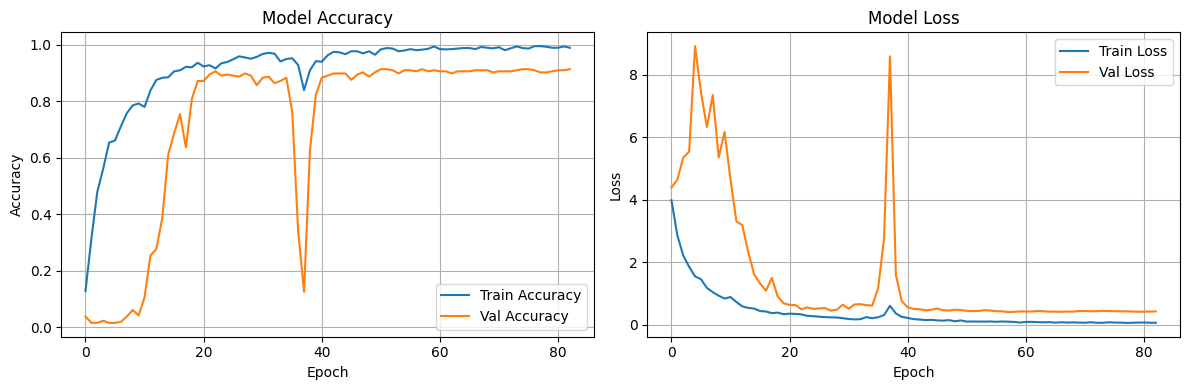

Training plots saved to: /kaggle/working/models/training_history.png


In [10]:
print("\n" + "=" * 50)
print("Generating Training Plots...")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(str(MODEL_DIR / 'training_history.png'), dpi=100)
plt.show()

print(f"Training plots saved to: {MODEL_DIR / 'training_history.png'}")

# Cell 9: Model Evaluation
Evaluate the model on the test set.


Evaluating Model (66 Classes)

📊 ACCURACY METRICS:
✓ Top-1 Accuracy: 91.29%
✓ Top-5 Accuracy: 95.45% (correct in top 5 predictions)
✓ Top-10 Accuracy: 97.35% (correct in top 10 predictions)

✓ High Confidence (≥75%) Accuracy: 98.71%
  Samples above threshold: 233 / 264 (88.3%)

✓ Average Confidence: 92.55%
  Min: 15.74% | Max: 100.00%

PER-CLASS PERFORMANCE (Top 10 & Bottom 10)

✅ TOP 10 BEST RECOGNIZED:
   1. 21-45902-3           - 100.0% (4 samples)
   2. 22-46138-1           - 100.0% (4 samples)
   3. 22-46139-1           - 100.0% (4 samples)
   4. 22-46141-1           - 100.0% (4 samples)
   5. 22-46275-1           - 100.0% (4 samples)
   6. 22-46293-1           - 100.0% (4 samples)
   7. 22-46342-1           - 100.0% (4 samples)
   8. 22-46473-1           - 100.0% (4 samples)
   9. 22-46536-1           - 100.0% (4 samples)
  10. 22-46590-1           - 100.0% (4 samples)

❌ BOTTOM 10 NEED IMPROVEMENT:
   1. 22-49609-3           -  75.0% (4 samples)
   2. 22-49783-3           -  75

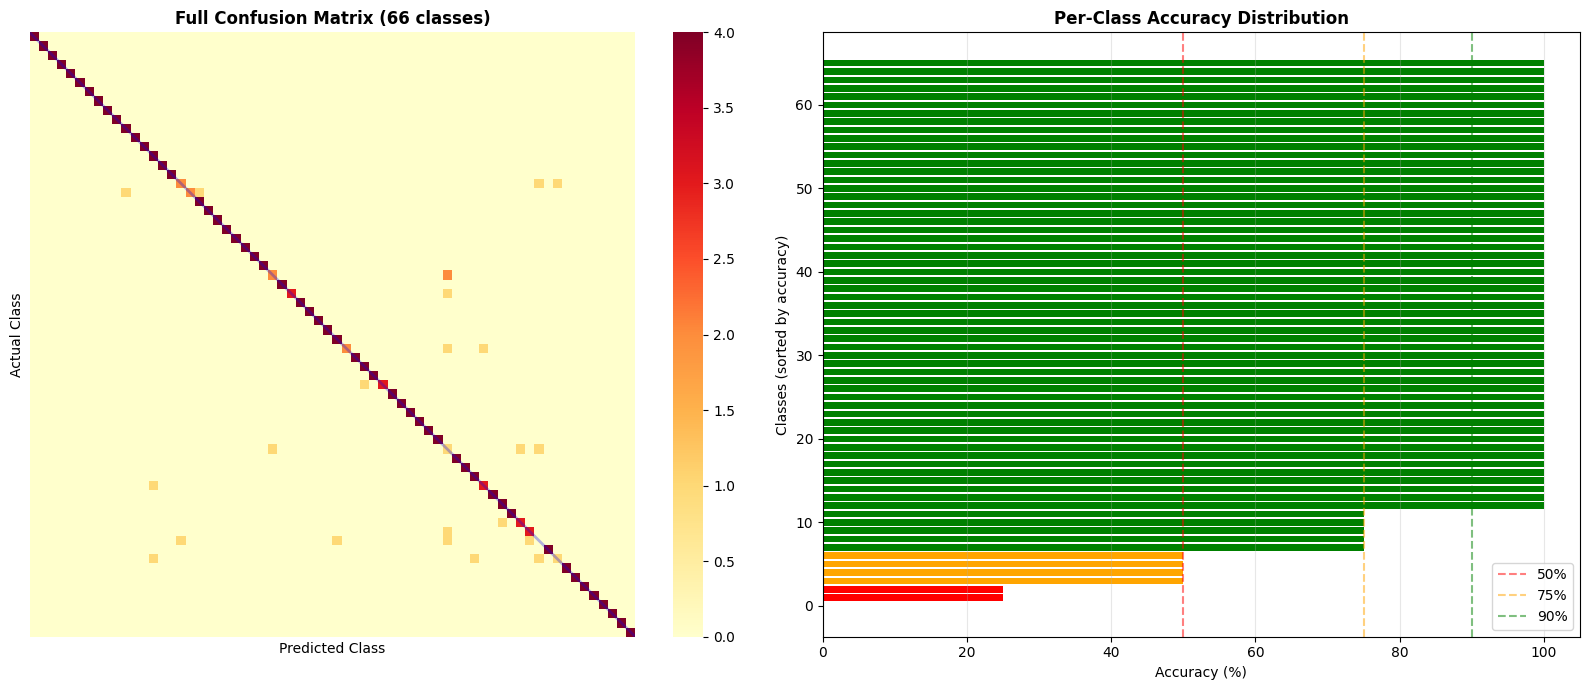


✓ Confusion matrix saved to: /kaggle/working/models/confusion_matrix_66class.png
✓ Diagonal accuracy: 91.29%


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import seaborn as sns

print("\n" + "=" * 50)
print("Evaluating Model (66 Classes)")
print("=" * 50)

# Make predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred_conf = np.max(y_pred_proba, axis=1)

# ==================================================
# COMPREHENSIVE ACCURACY METRICS
# ==================================================
print("\n📊 ACCURACY METRICS:")
print("=" * 50)

# 1. Overall accuracy
accuracy = np.mean(y_pred == y_test)
print(f"✓ Top-1 Accuracy: {accuracy * 100:.2f}%")

# 2. Top-5 accuracy (important for 66 classes)
top5_acc = top_k_accuracy_score(y_test, y_pred_proba, k=5)
print(f"✓ Top-5 Accuracy: {top5_acc * 100:.2f}% (correct in top 5 predictions)")

# 3. Top-10 accuracy
top10_acc = top_k_accuracy_score(y_test, y_pred_proba, k=10)
print(f"✓ Top-10 Accuracy: {top10_acc * 100:.2f}% (correct in top 10 predictions)")

# 4. High confidence accuracy
high_conf_mask = y_pred_conf >= MIN_CONFIDENCE
if high_conf_mask.sum() > 0:
    high_conf_acc = np.mean(y_pred[high_conf_mask] == y_test[high_conf_mask])
    print(f"\n✓ High Confidence (≥{MIN_CONFIDENCE*100:.0f}%) Accuracy: {high_conf_acc * 100:.2f}%")
    print(f"  Samples above threshold: {high_conf_mask.sum()} / {len(y_test)} ({high_conf_mask.sum()/len(y_test)*100:.1f}%)")
else:
    print(f"\n⚠ No predictions above {MIN_CONFIDENCE*100:.0f}% confidence threshold")

# 5. Average confidence
avg_conf = np.mean(y_pred_conf)
print(f"\n✓ Average Confidence: {avg_conf * 100:.2f}%")
print(f"  Min: {np.min(y_pred_conf) * 100:.2f}% | Max: {np.max(y_pred_conf) * 100:.2f}%")

# 6. Per-class accuracy summary
print("\n" + "=" * 50)
print("PER-CLASS PERFORMANCE (Top 10 & Bottom 10)")
print("=" * 50)

per_class_acc = []
for i in range(NUM_CLASSES):
    mask = y_test == i
    if mask.sum() > 0:
        acc = np.mean(y_pred[mask] == y_test[mask])
        per_class_acc.append((CLASS_NAMES[i], acc, mask.sum()))

# Sort by accuracy
per_class_acc.sort(key=lambda x: x[1], reverse=True)

print("\n✅ TOP 10 BEST RECOGNIZED:")
for i, (name, acc, count) in enumerate(per_class_acc[:10], 1):
    print(f"  {i:2d}. {name:20s} - {acc*100:5.1f}% ({count} samples)")

print("\n❌ BOTTOM 10 NEED IMPROVEMENT:")
for i, (name, acc, count) in enumerate(per_class_acc[-10:], 1):
    print(f"  {i:2d}. {name:20s} - {acc*100:5.1f}% ({count} samples)")

# ==================================================
# SIMPLIFIED CONFUSION MATRIX (for 66 classes)
# ==================================================
print("\n" + "=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)

cm = confusion_matrix(y_test, y_pred)

# For 66 classes, show a simplified heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left: Full confusion matrix (no labels)
sns.heatmap(cm, cmap='YlOrRd', cbar=True, ax=ax1, 
            xticklabels=False, yticklabels=False, linewidths=0)
ax1.set_title(f'Full Confusion Matrix ({NUM_CLASSES} classes)', fontsize=12, weight='bold')
ax1.set_xlabel('Predicted Class')
ax1.set_ylabel('Actual Class')

# Add diagonal line to show perfect predictions
ax1.plot([0, NUM_CLASSES], [0, NUM_CLASSES], 'b-', linewidth=2, alpha=0.3)

# Right: Per-class accuracy bar chart
class_accuracies = [acc for _, acc, _ in per_class_acc]
class_accuracies.sort()
ax2.barh(range(len(class_accuracies)), [a*100 for a in class_accuracies], 
         color=['red' if a < 0.5 else 'orange' if a < 0.75 else 'green' for a in class_accuracies])
ax2.set_xlabel('Accuracy (%)', fontsize=10)
ax2.set_ylabel('Classes (sorted by accuracy)', fontsize=10)
ax2.set_title('Per-Class Accuracy Distribution', fontsize=12, weight='bold')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50%')
ax2.axvline(x=75, color='orange', linestyle='--', alpha=0.5, label='75%')
ax2.axvline(x=90, color='green', linestyle='--', alpha=0.5, label='90%')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(str(MODEL_DIR / 'confusion_matrix_66class.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrix saved to: {MODEL_DIR / 'confusion_matrix_66class.png'}")
print(f"✓ Diagonal accuracy: {np.trace(cm) / np.sum(cm) * 100:.2f}%")

# Cell 10: Multi-Face Recognition Function
Core function for detecting and recognizing multiple faces in a frame.

In [12]:
def recognize_faces(image, model, class_names, confidence_threshold=MIN_CONFIDENCE):
    """
    Detect and recognize ALL faces in an image.
    Uses Haar Cascade for detection and CNN for recognition.

    Args:
        image: BGR image from camera or file
        model: Trained CNN model
        class_names: List of student IDs
        confidence_threshold: Minimum confidence for valid prediction

    Returns:
        List of (face_rect, student_id, confidence) tuples
    """
    results = []

    # Detect all faces using Haar Cascade
    faces = detect_multiple_faces(image)

    for face_rect in faces:
        # Extract face region
        face = extract_face(image, face_rect)

        if face is None:
            continue

        # Check face quality
        is_valid, reason = check_image_quality(face)
        if not is_valid:
            continue

        # Preprocess for CNN
        face_preprocessed = preprocess_image(face, (IMG_SIZE, IMG_SIZE))
        face_input = np.expand_dims(face_preprocessed, axis=0)

        # Predict
        predictions = model.predict(face_input, verbose=0)[0]
        pred_class = np.argmax(predictions)
        confidence = predictions[pred_class]

        # Only accept high confidence predictions (no false positives)
        if confidence >= confidence_threshold:
            student_id = class_names[pred_class]
        else:
            student_id = "Unknown"

        results.append((face_rect, student_id, confidence))

    return results


print("\nMulti-face recognition function ready!")
print(f"  - Confidence threshold: {MIN_CONFIDENCE * 100}%")
print(f"  - Classes: {CLASS_NAMES}")


Multi-face recognition function ready!
  - Confidence threshold: 75.0%
  - Classes: ['21-45902-3', '22-46138-1', '22-46139-1', '22-46141-1', '22-46275-1', '22-46293-1', '22-46342-1', '22-46473-1', '22-46536-1', '22-46590-1', '22-46666-1', '22-46679-1', '22-46887-1', '22-46945-1', '22-46983-1', '22-47180-1', '22-47294-1', '22-47402-2', '22-47884-2', '22-47892-2', '22-47894-2', '22-47898-2', '22-47925-2', '22-47968-2', '22-48055-2', '22-48064-2', '22-48091-2', '22-48133-2', '22-48205-2', '22-48434-3', '22-48541-3', '22-48569-3', '22-48582-3', '22-48833-3', '22-49037-3', '22-49068-3', '22-49167-3', '22-49196-3', '22-49338-3', '22-49355-3', '22-49370-3', '22-49405-3', '22-49411-3', '22-49421-3', '22-49422-3', '22-49451-3', '22-49453-3', '22-49507-3', '22-49575-3', '22-49609-3', '22-49629-3', '22-49643-3', '22-49745-3', '22-49783-3', '22-49791-3', '22-49800-3', '22-49824-3', '22-49843-3', '22-49852-3', '22-49861-3', '22-49862-3', '23-50158-1', '23-50279-1', '23-50346-1', '23-51127-1', '23-

# Cell 11: Attendance Tracking Class
Class for tracking student attendance and preventing duplicates.

In [13]:
class AttendanceTracker:
    """
    Track student attendance with duplicate prevention.
    """

    def __init__(self, class_names, cooldown_seconds=60):
        self.class_names = class_names
        self.cooldown = cooldown_seconds
        self.attendance = {}  # {student_id: (first_seen, last_seen, count)}
        self.session_start = datetime.now()

    def mark_present(self, student_id, confidence):
        """
        Mark a student as present.

        Args:
            student_id: Student identifier
            confidence: Prediction confidence

        Returns:
            True if newly marked, False if already marked
        """
        if student_id == "Unknown":
            return False

        now = datetime.now()

        if student_id in self.attendance:
            first_seen, last_seen, count = self.attendance[student_id]
            # Check cooldown
            if (now - last_seen).seconds < self.cooldown:
                self.attendance[student_id] = (first_seen, now, count)
                return False
            self.attendance[student_id] = (first_seen, now, count + 1)
        else:
            self.attendance[student_id] = (now, now, 1)
            print(f"✓ {student_id} marked PRESENT (confidence: {confidence:.1%})")

        return True

    def get_summary(self):
        """Get attendance summary string."""
        present = len(self.attendance)
        total = len(self.class_names)
        return f"Present: {present}/{total}"

    def save_to_csv(self, filepath=None):
        """
        Save attendance to CSV file.

        Args:
            filepath: Optional custom path

        Returns:
            Path to saved file
        """
        if filepath is None:
            timestamp = self.session_start.strftime("%Y%m%d_%H%M%S")
            filepath = ATTENDANCE_DIR / f'attendance_{timestamp}.csv'

        with open(filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Student_ID', 'First_Seen', 'Last_Seen', 'Detections', 'Status'])

            for student_id in self.class_names:
                if student_id in self.attendance:
                    first, last, count = self.attendance[student_id]
                    writer.writerow([
                        student_id,
                        first.strftime('%H:%M:%S'),
                        last.strftime('%H:%M:%S'),
                        count,
                        'Present'
                    ])
                else:
                    writer.writerow([student_id, '', '', 0, 'Absent'])

        print(f"\nAttendance saved to: {filepath}")
        return str(filepath)


print("Attendance tracking system ready!")

Attendance tracking system ready!


# Cell 12: Real-Time Attendance System
Run the camera-based attendance system.

In [16]:
def run_realtime_attendance(model, class_names, camera_id=0, duration_seconds=None):
    """
    Run real-time attendance system using camera.

    Controls:
        'q' - Quit and save attendance
        's' - Save attendance immediately

    Args:
        model: Trained CNN model
        class_names: List of student IDs
        camera_id: Camera device ID
        duration_seconds: Auto-stop after N seconds (None for manual)

    Returns:
        AttendanceTracker object with results
    """
    print("\n" + "=" * 50)
    print("REAL-TIME ATTENDANCE SYSTEM")
    print("=" * 50)
    print("Controls: 'q' = quit | 's' = save")
    print(f"Confidence threshold: {MIN_CONFIDENCE * 100}%")
    print("=" * 50 + "\n")

    # Open camera
    cap = cv2.VideoCapture(camera_id)
    if not cap.isOpened():
        print("ERROR: Could not open camera!")
        return None

    # Initialize tracker
    tracker = AttendanceTracker(class_names)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Recognize faces
        results = recognize_faces(frame, model, class_names)

        # Draw results
        for face_rect, student_id, confidence in results:
            x, y, w, h = face_rect
            tracker.mark_present(student_id, confidence)

            # Simple color: green for recognized, red for unknown
            color = (0, 255, 0) if student_id != "Unknown" else (0, 0, 255)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)

            # Label
            label = f"{student_id}: {confidence:.0%}"
            cv2.putText(frame, label, (x, y - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Simple status
        cv2.putText(frame, tracker.get_summary(), (10, 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        cv2.imshow('Attendance', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            tracker.save_to_csv()
            break
        elif key == ord('s'):
            tracker.save_to_csv()

    cap.release()
    cv2.destroyAllWindows()
    print(f"\nFinal: {tracker.get_summary()}")
    return tracker


print("\n" + "=" * 50)
print("TRAINING COMPLETE!")
print("=" * 50)
print("\nTo test with camera, uncomment and run:")
print("  tracker = run_realtime_attendance(model, CLASS_NAMES)")
print("\nTo test with an image:")
print("  results = recognize_faces(cv2.imread('path/to/image.jpg'), model, CLASS_NAMES)")
print("  for face_rect, name, conf in results:")
print("      print(f'{name}: {conf:.1%}')")


TRAINING COMPLETE!

To test with camera, uncomment and run:
  tracker = run_realtime_attendance(model, CLASS_NAMES)

To test with an image:
  results = recognize_faces(cv2.imread('path/to/image.jpg'), model, CLASS_NAMES)
  for face_rect, name, conf in results:
      print(f'{name}: {conf:.1%}')


In [17]:
if __name__ == "__main__":
    tracker = run_realtime_attendance(model, CLASS_NAMES)


REAL-TIME ATTENDANCE SYSTEM
Controls: 'q' = quit | 's' = save
Confidence threshold: 75.0%

ERROR: Could not open camera!


[ WARN:0@1749.013] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@1749.013] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range


# Sample Predictions Visualization
Visualize 10 random test images with actual vs predicted student IDs.


Sample Predictions Visualization


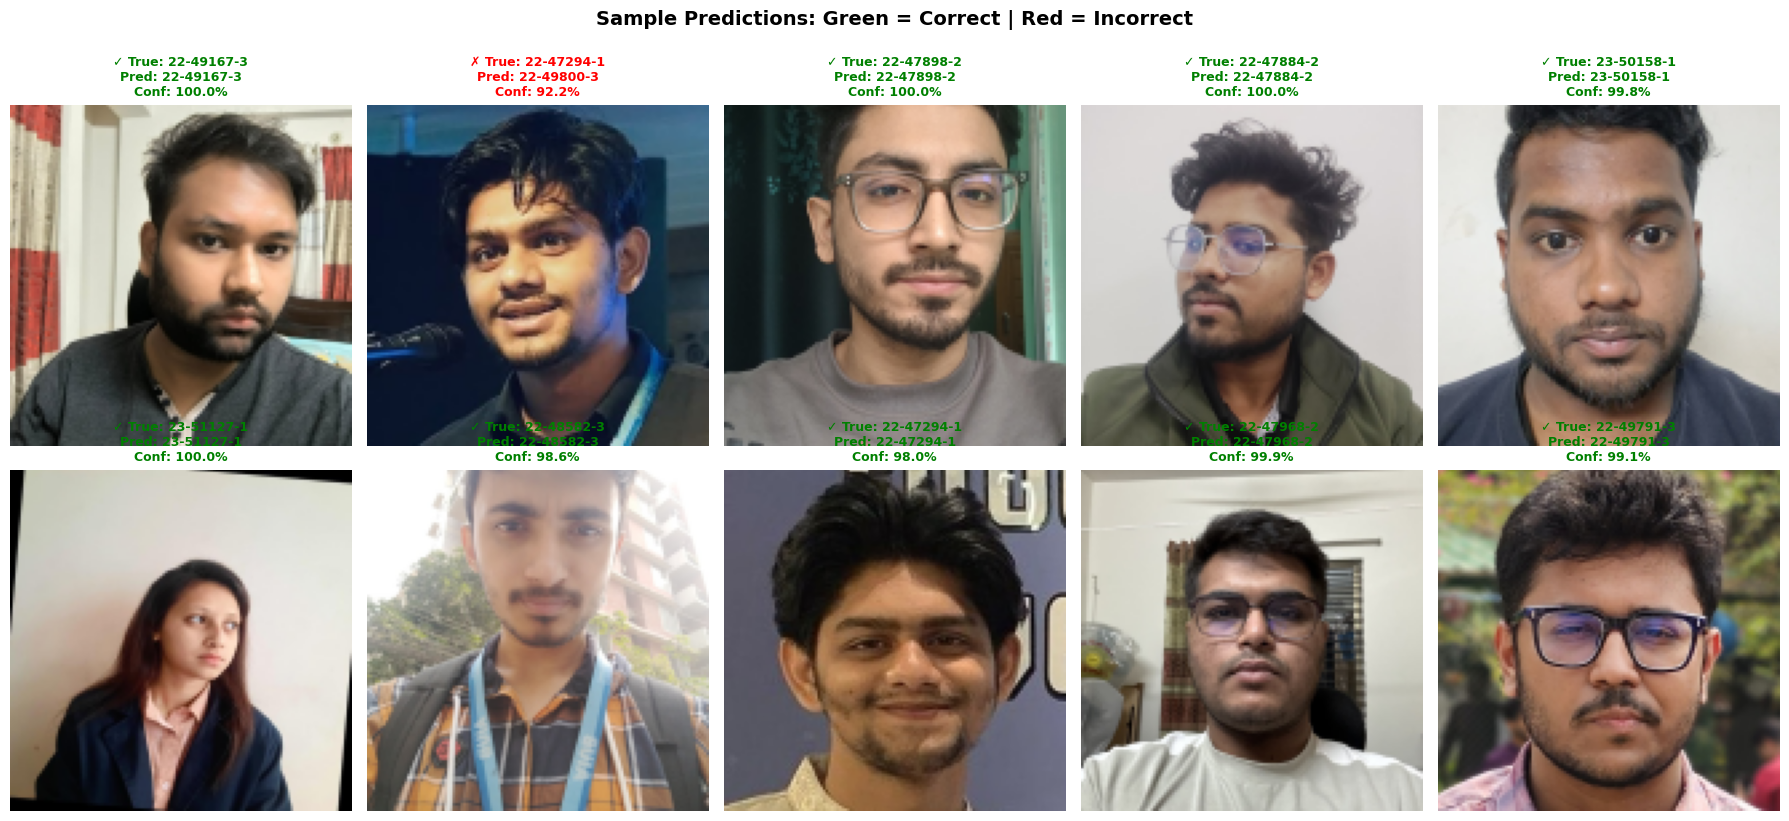


Detailed Predictions:
--------------------------------------------------------------------------------
#   True ID              Predicted ID         Confidence   Status    
--------------------------------------------------------------------------------
1   22-49167-3           22-49167-3            99.95%      ✓ CORRECT
2   22-47294-1           22-49800-3            92.20%      ✗ WRONG
3   22-47898-2           22-47898-2            99.96%      ✓ CORRECT
4   22-47884-2           22-47884-2            99.98%      ✓ CORRECT
5   23-50158-1           23-50158-1            99.83%      ✓ CORRECT
6   23-51127-1           23-51127-1            99.97%      ✓ CORRECT
7   22-48582-3           22-48582-3            98.64%      ✓ CORRECT
8   22-47294-1           22-47294-1            98.00%      ✓ CORRECT
9   22-47968-2           22-47968-2            99.89%      ✓ CORRECT
10  22-49791-3           22-49791-3            99.14%      ✓ CORRECT
---------------------------------------------------------

In [18]:
print("\n" + "=" * 50)
print("Sample Predictions Visualization")
print("=" * 50)

# Select 10 random test images
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

# Create predictions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, test_idx in enumerate(sample_indices):
    # Get image and true label
    img = X_test[test_idx]
    true_label = y_test[test_idx]
    true_name = CLASS_NAMES[true_label]
    
    # Make prediction
    img_input = np.expand_dims(img, axis=0)
    predictions = model.predict(img_input, verbose=0)[0]
    pred_label = np.argmax(predictions)
    pred_name = CLASS_NAMES[pred_label]
    confidence = predictions[pred_label]
    
    # Display image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Set title with color coding
    if true_label == pred_label:
        color = 'green'
        status = '✓'
    else:
        color = 'red'
        status = '✗'
    
    title = f"{status} True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1%}"
    axes[idx].set_title(title, fontsize=9, color=color, weight='bold')

plt.suptitle('Sample Predictions: Green = Correct | Red = Incorrect', 
             fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(str(MODEL_DIR / 'sample_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print detailed results
print("\nDetailed Predictions:")
print("-" * 80)
print(f"{'#':<3} {'True ID':<20} {'Predicted ID':<20} {'Confidence':<12} {'Status':<10}")
print("-" * 80)

for idx, test_idx in enumerate(sample_indices, 1):
    true_label = y_test[test_idx]
    true_name = CLASS_NAMES[true_label]
    
    img_input = np.expand_dims(X_test[test_idx], axis=0)
    predictions = model.predict(img_input, verbose=0)[0]
    pred_label = np.argmax(predictions)
    pred_name = CLASS_NAMES[pred_label]
    confidence = predictions[pred_label]
    
    status = "✓ CORRECT" if true_label == pred_label else "✗ WRONG"
    print(f"{idx:<3} {true_name:<20} {pred_name:<20} {confidence*100:>6.2f}%      {status}")

print("-" * 80)
correct = sum([1 for test_idx in sample_indices if y_test[test_idx] == np.argmax(model.predict(np.expand_dims(X_test[test_idx], axis=0), verbose=0))])
print(f"Sample Accuracy: {correct}/10 ({correct*10}%)")
print(f"\n✓ Visualization saved to: {MODEL_DIR / 'sample_predictions.png'}")